# Experimentation - LSTM in Climate Change - ERA5 to ERA5 (Univariable)

## Configs:

This notebook aims to predict the total precipitation value in Alegrete via LSTM using ERA5 to train and test.

- __Training time:__ 1980 - 2025
- __Window size:__ 364 days
- __Horizon:__ 1 day
- __Preprocessing:__ None
- __Place:__ Alegrete INMET Station
- __Training variables:__ Total Precipitation
- __Features__: Total Precipitation

## Workflow:
1. Load and inspect data
2. Create input/output sequences
3. Scale and reshape data
4. Train an LSTM model
5. Generate and evaluate forecasts

In [ ]:
# Imports

# Libraries
import numpy as np
import tensorflow as tf
import xarray as xr
import matplotlib.pyplot as plt

# Built-in functions
from src.data import load_interim
from src.data.preprocess import create_sliding_windows, prepare_data_seq_to_one
from src.models.tensorflow.architectures import build_lstm_seq_to_vec
from src.data.split import temporal_train_val_test_split
from src.models.tensorflow.train import train_timeseries_model
from src.evaluation.plots import plot_training_history, plot_real_vs_predicted_scatter, plot_real_vs_predicted_scatter_no_outliers
from src.evaluation.metrics import mae


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load and inspect data

In [3]:
# Loads the data from alegrete
path = load_interim('era5_precipitation_timeseries_alegrete_1D.nc')

nc_dataset = xr.open_dataset(path, engine="netcdf4")

# Saves the variable tp = Total Precipitation
tp = nc_dataset["tp"]
df = tp.to_dataframe(name="total_precipitation")

print(df)

            latitude  longitude  total_precipitation
valid_time                                          
1979-01-01    -29.75      -55.5             0.171185
1979-01-02    -29.75      -55.5             0.332832
1979-01-03    -29.75      -55.5             0.007153
1979-01-04    -29.75      -55.5             0.000000
1979-01-05    -29.75      -55.5             0.000000
...              ...        ...                  ...
2025-12-27    -29.75      -55.5            11.691570
2025-12-28    -29.75      -55.5            21.647930
2025-12-29    -29.75      -55.5            42.373180
2025-12-30    -29.75      -55.5             0.635624
2025-12-31    -29.75      -55.5             1.400471

[17167 rows x 3 columns]


## 2. Create input/output sequences

### Sequence configuration

- Timesteps (input window): 364 days
- Lead time (forecast horizon): 1 day ahead

### Create sliding windows

In [4]:
TIMESTEPS = 364    # past days used as input
HORIZON = 1       # predict 1 day ahead

#series = df["total_precipitation"]
initial_date = "1980-01-01"
end_date = "2025-12-31"

series = df.loc[initial_date:end_date]["total_precipitation"]

X, y = create_sliding_windows(series, TIMESTEPS, HORIZON)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (16438, 364)
y shape: (16438, 1)


## 3. Scale and Reshape data

In [5]:
# Scale the data
X_scaled, y_scaled, scaler_x, scaler_y = prepare_data_seq_to_one(X, y, num_features=1)

# Split the data into Train, Validation and Test
X_train, X_val, X_test, y_train, y_val, y_test = temporal_train_val_test_split(X_scaled, y_scaled,0.7,0.2)

print("Dataset sizes")
print("=========================")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Dataset sizes
Train: (11506, 364, 1)
Val: (3288, 364, 1)
Test: (1644, 364, 1)


## 4. Train LSTM model

In [ ]:
model = build_lstm_seq_to_vec(
    horizon=HORIZON,
    timesteps=TIMESTEPS,
    num_features=1,
    activation="tanh"
)

history = train_timeseries_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val
)

print(model.summary())

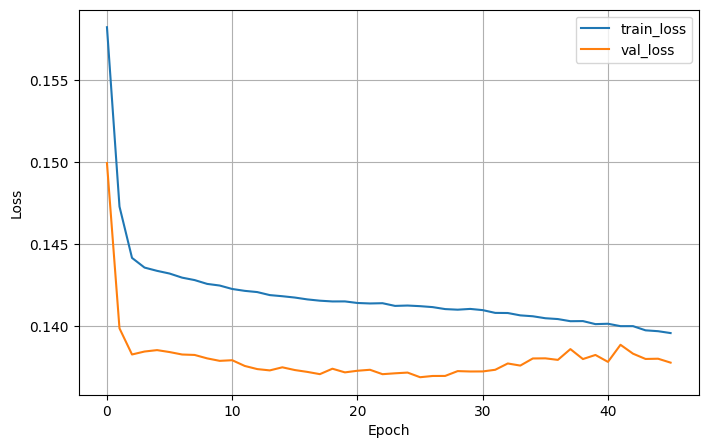

In [7]:
fig = plot_training_history(history)
plt.show()

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
y_true stats:
 min: 0.0
 max: 103.2343
 mean: 4.426473

y_pred stats:
 min: -0.010180993
 max: 7.338558
 mean: 0.87073183


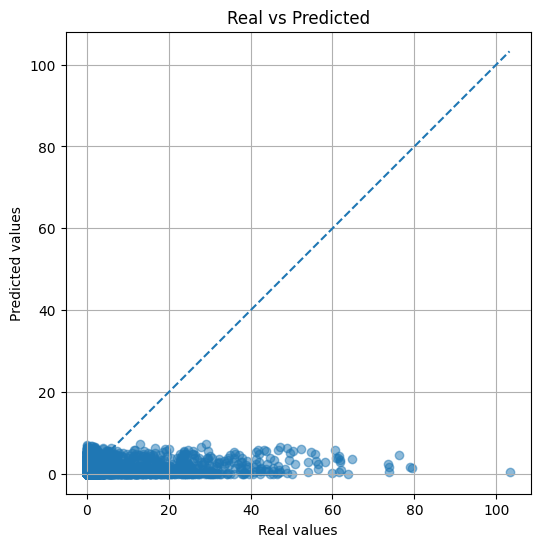

In [8]:
y_pred_scaled = model.predict(X_val)

y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_true = scaler_y.inverse_transform(y_val.squeeze(-1))

y_true = y_true.squeeze()
y_pred = y_pred.squeeze()

print("y_true stats:")
print(" min:", y_true.min())
print(" max:", y_true.max())
print(" mean:", y_true.mean())

print("\ny_pred stats:")
print(" min:", y_pred.min())
print(" max:", y_pred.max())
print(" mean:", y_pred.mean())

fig = plot_real_vs_predicted_scatter(y_true, y_pred)
plt.show()

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
y_true stats:
 min: 0.0
 max: 75.00696
 mean: 3.9567728

y_pred stats:
 min: -0.010482566
 max: 7.2153788
 mean: 0.7815705
Test MAE: 3.934


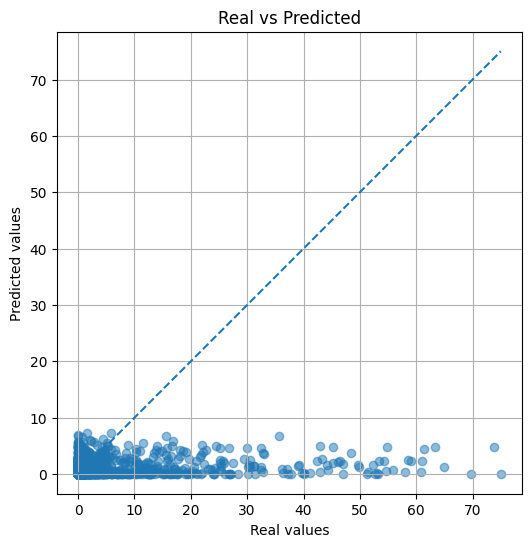

In [9]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_true = y_true.squeeze()
y_pred = y_pred.squeeze()

mae_value = mae(y_true.squeeze(), y_pred)
print(f"Test MAE: {mae_value:.3f}")

fig = plot_real_vs_predicted_scatter(y_true, y_pred)
plt.show()

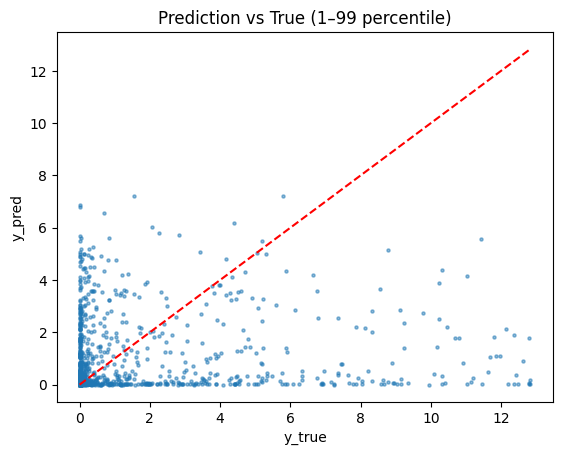

In [15]:
fig = plot_real_vs_predicted_scatter_no_outliers(y_true, y_pred,1,90)
plt.show()

In [ ]:
y_persist = y_true[:-1]
y_true_cut = y_true[1:]

print("Persistence MAE:", mae(y_true_cut, y_persist))
print("Model MAE:", mae(y_true, y_pred))